In [1]:
import pandas as pd
import numpy as np

ratings='../Data/ml-latest/ratings.csv'
movies='../Data/ml-latest/movies.csv'

df_ratings=pd.read_csv(ratings, usecols=['movieId','userId','rating'],
    dtype={
        'movieId':'int32',
        'userId':'int32',
        'rating':'float32',
        }
    )

df_movies=pd.read_csv(movies, usecols=['movieId','genres','title'],
    dtype={
        'movieId':'int32',
        'genres':'str',
        'title':'str',
        }
    )

In [2]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int32  
 1   movieId  int32  
 2   rating   float32
dtypes: float32(1), int32(2)
memory usage: 317.6 MB


In [3]:
total_users = len(df_ratings['userId'].unique()) # same as len(df_ratings.groupby('userId').count())
total_users

283228

In [4]:
avg_ratings_per_user = df_ratings.groupby('userId')['rating'].count().mean()

The average amount of rating is 98, well let's say 100.

In [5]:
rating_count = df_ratings['rating'].value_counts()
rating_count

4.0    7394710
3.0    5515668
5.0    4071135
3.5    3404360
4.5    2373550
2.0    1850627
2.5    1373419
1.0     886233
0.5     442388
1.5     441354
Name: rating, dtype: int64

Wide spread in amount of ratings, with 4 stars being submitted the most and 1.5 the least.

## Creating df for genres, titles and release year

In [6]:
df = df_movies['genres'].str.get_dummies('|')          # Split the genres column into boolean columns
df.drop('(no genres listed)', axis=1, inplace=True)    # Drop movies with no genre listed
df = pd.concat([df, df_movies], axis=1)                # Join with original df_movies
df.drop('genres', axis=1, inplace=True)                # Drop original column with genres

import re
df['year'] = df['title'].str.extract(                   # Create new column with year extracted
        r'\((\d{4})\)', expand=False)
        
df['title'] = df['title'].str.replace(                  # Remove year from title column
        r' \(\d{4}\)', '', regex=True)

In [7]:
df.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movieId,title,year
0,0,1,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,Toy Story,1995
1,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,2,Jumanji,1995
2,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,3,Grumpier Old Men,1995
3,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,4,Waiting to Exhale,1995
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,5,Father of the Bride Part II,1995


### Find most popular genres

In [8]:
all_genres = df.drop(['title', 'year'], axis=1)
all_genres.loc[:,all_genres.columns != 'movieId'].sum().sort_values(ascending=False)


Drama          24144
Comedy         15956
Thriller        8216
Romance         7412
Action          7130
Horror          5555
Documentary     5118
Crime           5105
Adventure       4067
Sci-Fi          3444
Mystery         2773
Children        2749
Animation       2663
Fantasy         2637
War             1820
Western         1378
Musical         1113
Film-Noir        364
IMAX             197
dtype: int64

Not sure if IMAX really is a genre. It's more of an exclusive proprietary system. I'm gonna drop that column. Lets first make sure there are no movies which only has the IMAX genre:

In [9]:
#num_imax_movies = (df.sum(axis=1) == 1).sum()

if (num_imax_movies := (all_genres.sum(axis=1) == 1).sum()) == 0:
    print(f"Dropped column.")
    df.drop(['IMAX'], axis=1, inplace=True)
    all_genres.drop(['IMAX'], axis=1, inplace=True)
    
else:
    print("Not dropped")
    print(f"{num_imax_movies} movies have only the IMAX column equal to 1.")

Dropped column.


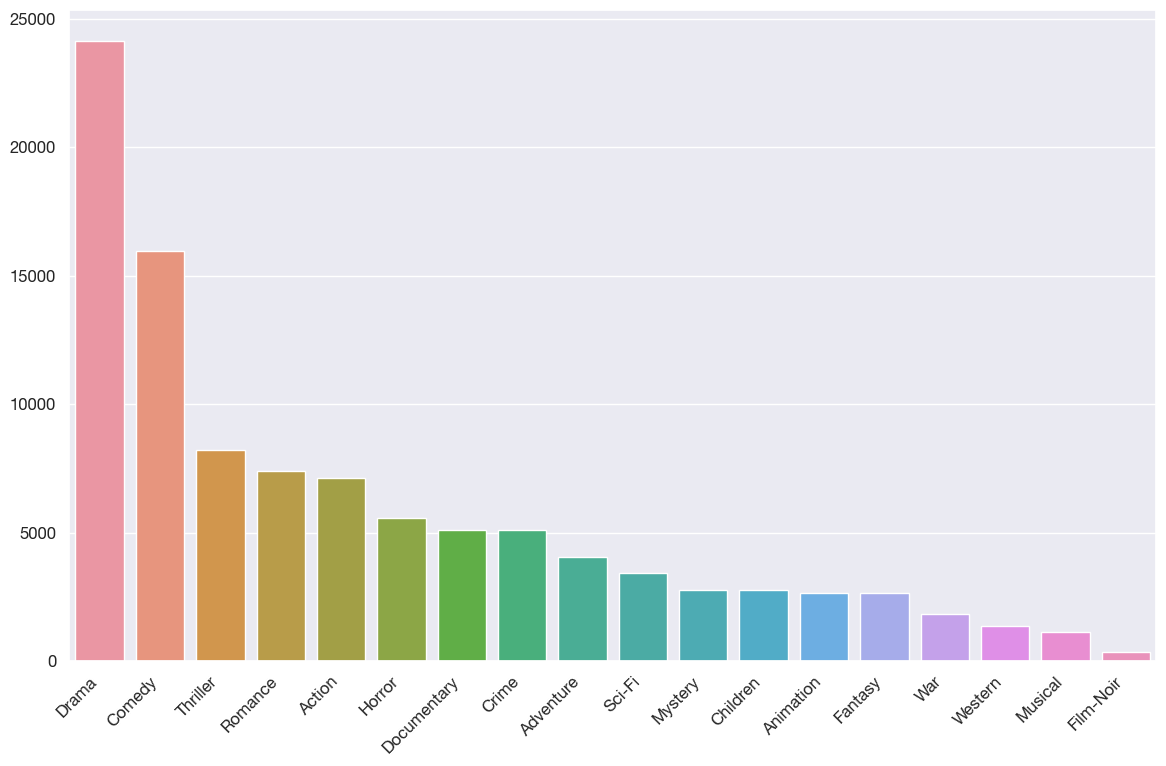

In [10]:
# Speaking of genres, I don't think I plotted this yet?

import seaborn as sns
import matplotlib.pyplot as plt

genre_counts = all_genres.loc[:,all_genres.columns != 'movieId'].sum().sort_values(ascending=False)

plt.figure(figsize=(12,8))
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.set(font_scale=1.5, rc={"font.family": "Helvetica Neue"})
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [11]:
df.tail()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movieId,title,year
58093,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,193876,The Great Glinka,1946
58094,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,193878,Les tribulations d'une caissière,2011
58095,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,193880,Her Name Was Mumu,2016
58096,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,193882,Flora,2017
58097,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,193886,Leal,2018


I really want to add the average rating as a column as well. To do that, we have to run a shit ton of mean calculations for every movieId in the user rating dataset. So perhaps we should clean the ratings a bit first.

## Some ideas to get a better mean rating and make the data more manageable

- Remove users who rated >6000 movies

- Remove users who rated <50 movies

- Remove users who only gave 0.5 star ratings

- Remove users who only gave 5 star ratings

- Set upper bound for amount of ratings (how to do this fair?)

### Remove all users who only submitted lowest possible reviews

In [12]:
mask = df_ratings.groupby('userId')['rating'].unique().apply(lambda x: len(x)==1 and x[0]==0.5)
print(f"Found {len(mask[mask].index)} users who only submitted 0.5 star reviews")

Found 259 users who only submitted 0.5 star reviews


Great, now lets remove all ratings made by these 259 users, it should be 1182 rows based on previous EDA. TODO: add link

In [13]:
users_to_remove = mask[mask].index.tolist()
filtered_df = df_ratings[~df_ratings['userId'].isin(users_to_remove)]

### Remove all users who submitted < n reviews

In [14]:
n = 50
users_with_few_ratings = df_ratings['userId'].value_counts()[lambda x: x < n].index.tolist()
print(f"Found {len(users_with_few_ratings)} users who submitted less than {n} ratings.")

Found 173556 users who submitted less than 50 ratings.


Here I'm not sure where to set n. We'll have to experiment.

In [15]:
filtered_df = filtered_df[~filtered_df['userId'].isin(users_with_few_ratings)]

In [16]:
def get_percentage(old, new):
    return (new - old) / old * 100

get_percentage(len(df_ratings), len(filtered_df))

-11.726631116484137

So far we have only reduced the dataset by 12% Let's continue.

### Remove all users who submitted > n reviews

In [17]:
def count_users(df_ratings, n, verbose=True):
    users_found = df_ratings.groupby('userId')['rating'].count()
    users_found = users_found[users_found > n]
    if verbose:
        print(f'{len(users_found)} users found with > {n} ratings made:')
    
    top_dedicated = [] # we'll use this later
    ratings_by_top = []
    
    for user_id, num_ratings in users_found.items():
        #print(f'User {user_id}: {num_ratings} ratings')
        top_dedicated.append(user_id)
        ratings_by_top.append(num_ratings)
    
    if verbose:
        print(f'{sum(ratings_by_top)} rows to be removed if {n=}')
 
n_values = [200, 500, 1000, 1500, 3000, 6000]
results = []

for n in n_values:
    print(f"Running with n={n}")
    count_users(df_ratings, n)
    users_found = df_ratings.groupby('userId')['rating'].count()
    users_found = users_found[users_found > n]
    result = {'n': n, 'num_users': len(users_found), 'num_rows': sum(users_found)}
    results.append(result)


Running with n=200
35004 users found with > 200 ratings made:
16951891 rows to be removed if n=200
Running with n=500
10221 users found with > 500 ratings made:
9334236 rows to be removed if n=500
Running with n=1000
2774 users found with > 1000 ratings made:
4287475 rows to be removed if n=1000
Running with n=1500
920 users found with > 1500 ratings made:
2068386 rows to be removed if n=1500
Running with n=3000
120 users found with > 3000 ratings made:
500792 rows to be removed if n=3000
Running with n=6000
8 users found with > 6000 ratings made:
76163 rows to be removed if n=6000


Ok, nice, the function works, let's run it with more values and plot the results.

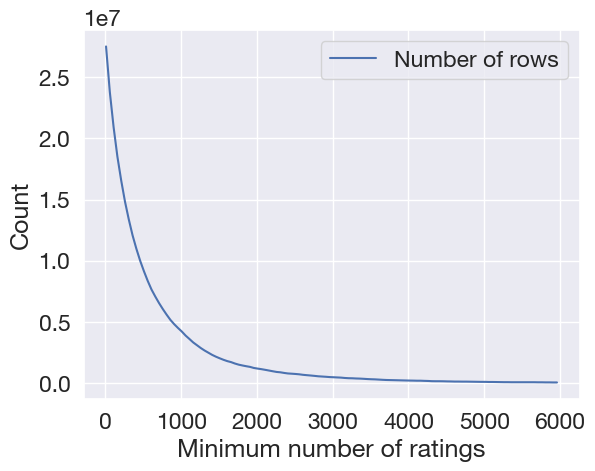

In [18]:
n_values = np.arange(10, 6010, 50).tolist()
results = []

for n in n_values:
    count_users(df_ratings, n, verbose=False)
    users_found = df_ratings.groupby('userId')['rating'].count()
    users_found = users_found[users_found > n]
    result = {'n': n, 'num_users': len(users_found), 'num_rows': sum(users_found)}
    results.append(result)

num_users = [r['num_users'] for r in results]
num_rows = [r['num_rows'] for r in results]

fig, ax = plt.subplots()
ax.plot(n_values, num_rows, label='Number of rows')
ax.set_xlabel('Minimum number of ratings')
ax.set_ylabel('Count')
ax.legend()
plt.show()


(1e7 = 10,000,000)

Now it's a bit easier to make a decision on where to cut the high end of users. I will make the cut at n=510, reducing the dataset by 9 153 392 rows

#### **This means that users who rated >510 movies will not be factored in!! Is this a good thing? Is this a bad thing? Depends.**

For speed its good, for accuracy, maybe as well? We will have to keep experimenting.

In [19]:
mask = df_ratings['userId'].value_counts() > 510
users_to_remove = mask[mask].index.tolist()

# filter out the corresponding rows from the original dataframe
filtered_df = filtered_df[~filtered_df['userId'].isin(users_to_remove)]

In [20]:
get_percentage(len(df_ratings),len(filtered_df))

-44.70773429056228

Almost 50% reduced! That should be good enough! But lets check which movies are left with very few ratings.

### Remove all movies with < n reviews

In [21]:
n = 20

movie_counts = filtered_df['movieId'].value_counts()
movies_below_n_occurrences = movie_counts[movie_counts < n].index.tolist()
#movie_titles = titles.set_index('movieId')['title'].loc[movies_below_n_occurrences]

print(f"Found {len(movies_below_n_occurrences)} movies with less than {n} ratings.")
#print(f"Movies with less than {n} occurrences:")
#print(movie_titles[:10].to_string())

Found 22166 movies with less than 20 ratings.


In the original unmodified ratings dataset, there are 35523 movies with < 20 ratings.

35523 - 35444 = 79, so I guess that's ok. We will create a special bucket for all movies with < 20 ratings anyway.

In [22]:
filtered_df = filtered_df.drop(filtered_df[filtered_df['movieId'].isin(movies_below_n_occurrences)].index)

73496700 - 73016511 = 480 198 => an additional .5 mil rows dropped by removing the 3544 movies with < 20 ratings.

But I'm getting a bit worried. How many movies have we dropped in total?

In [23]:
len(filtered_df['movieId'].unique()), len(df_ratings['movieId'].unique())

(11612, 53889)

Oh no...

In [60]:
print(f'Rows reduced by {(abs(get_percentage(len(df_ratings),len(filtered_df)))):.2f}%')
print(f"Unique movies lost: {len(df_ratings['movieId'].unique()) - len(filtered_df['movieId'].unique())}")
print(f"Movies lost by {abs(get_percentage(len(df_ratings['movieId'].unique()), len(filtered_df['movieId'].unique()))):.2f}%")

Rows reduced by 45.03%
Unique movies lost: 42277
Movies lost by 78.45%


## Oh no...

Well. Let's not remove movies with <20 ratings, instead maybe remove movies with <10 ratings. That would add like 5k movies and not really change much in the rows reduced data weight.

In [67]:
# theoretically we would get something like

print(f'Rows reduced by {(abs(get_percentage(len(df_ratings),len(filtered_df))))-0.1:.2f}%')
print(f"Unique movies lost: {len(df_ratings['movieId'].unique()) - len(filtered_df['movieId'].unique())-5000}")
print(f"Movies lost by {abs(get_percentage(len(df_ratings['movieId'].unique()), len(filtered_df['movieId'].unique())+5000)):.2f}%")

Rows reduced by 44.93%
Unique movies lost: 37277
Movies lost by 69.17%


If my calculations are correct, we get a drastic decrease in lost movies (78.45% -> 69.17%) while only adding about 1% of total rows.

That sounds like a no-brainer. But 10 ratings is the absolute lowest I'm willing to go for two reasons:

1. On a scale of 1-10 (0.5 to 5.0), 10 ratings is barely enough for a fair mean. Ratings *will* be skewed for some movies.

2. When segmenting users, movies with fewer users creates broader, harder to define user segments. While for the end-user, this might seem like a good thing, broader user groups also creates more nische and personal filter bubbles. So it's actually narrow for the user. But it's broad, or rather many, groups to compute, which is costly.

So let's remember that, let's make it a H2

## Remove all users who submitted > n reviews (try n = 10)

# What we should really do

What we really need to do, is to attack the enormous amount of ratings the top rated movies have. I've stated this early on in some of my other ipynbs, I'm not just quite sure how to do it without first segmenting groups. For example:

- 10,000 users rated Matrix, Bladerunner, The Terminator 4.5 or 5.0, they also gave The Notebook and Eternal Sunshine of the Spotless Mind ratings < 2.5:<br>
This segment can be called Sci-Fi-Enjoyer, because they rated sci-fi movies high and non-sci-fi movies low.

- 80,000 users rated Forrest Gump, Matrix, Pulp Fiction, The Terminator 4.5 or 5.0 but gave lesser known movies/movies with few ratings bad scores <2.5:<br>
This segment can be called Blockbusters, because they rated very popular movies high and rarely gave high scores to lesser known movies.

- 50,000 users rated Saving Private Ryan, Pearl Harbor, Dunkirk, and Black Hawk Down 4.5 or 5.0, but gave movies like The Notebook and 500 Days of Summer ratings < 2.5:<br>
This segment can be called War-Movie-Fans, because they rated war movies high and non-war movies low.

- 30,000 users rated Titanic, The Notebook, and A Walk to Remember 4.5 or 5.0, but gave action and sci-fi movies ratings < 2.5:<br>
This segment can be called Romance-Lovers, because they rated romantic movies high and action/sci-fi movies low.

- 20,000 users rated The Godfather, Scarface, and Goodfellas 4.5 or 5.0, but gave animated and family movies ratings < 2.5:<br>
This segment can be called Crime-Drama-Fans, because they rated crime drama movies high and animated/family movies low.

.. And so on.

By segmenting users like this. We can *then* start removing rows based on **user category** rather than userId or movieId or ratings.

But the thing is, to actually start running segmentations, we first need to cut the ratings dataset. Ugh. Its like that movie, Catch-22.


Wait, I think I got it. What if. What if we segment the users while reading in the data?

We read each userId, one rating a time, and within a set of rules decide which segment they should belong. Like, the sorting hat from Harry Potter.

Then we keep pouring userId:s in until every segment has been filled, let's say with 1000 users, or whatever.

Then we can keep mean rating in another dataframe.

It might be stupid, but I mean it makes sense to me? I should try it.